In [125]:
# Imports
from utils import (plot_mean_bar,
                   get_target,
                   categorical_cardinality,
                   categorical_mean)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from joblib import dump, load
from pathlib import Path
from IPython.display import display
from sklearn import set_config
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold,
                                     cross_val_score,
                                     cross_val_predict,
                                     GridSearchCV)
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.dummy import DummyClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,IterativeImputer
from sklearn.metrics import (average_precision_score,
                             f1_score,
                             make_scorer,
                             precision_recall_curve,
                             confusion_matrix,
                             plot_precision_recall_curve,
                             plot_roc_curve,
                             plot_confusion_matrix)
from sklearn.inspection import permutation_importance

# Notebook Settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 5]
set_config(display="diagram")

############# Caminhos dos Arquivos de Entrada ########################

input_folder = ".."
studentInfo_data = "studentInfo.csv"
studentAssessment_data = "studentAssessment.csv"
assessments_data = "assessments.csv"
studentVle_data = "studentVle.csv"
vle_data = "vle.csv"

#######################################################################

############## Parametros Gerais ############################

TEST_SIZE = 0.10
RANDOM_SEED = 42


**Disclaimer**: O texto em português contem diversas omissões de acentuação devido a escrito ao teclado nórdico que uso. Deste modo, escrever å torna-se mais fácil do que escrever ç. Perdoem-me :)

# 1. Primeiro Experimento

Nosso primeiro modelo (experimento) leva em conta apenas os atributos contidos no *dataset* **studentInfo**. 

## 1.1 Exploração do  *studentInfo Dataset*

Começaremos explorando o dataset studentInfo pois o temos como a espinha dorsal do primeiro modelo que construiremos para resolver a questão de negócios que nos propusemos a resolver: **Quais estudantes falharão no Exame Final?**


In [2]:
info = pd.read_csv(Path(input_folder,studentInfo_data),low_memory=False)

In [3]:
f'Info Dataset Contem {info.shape[0]} linhas e {info.shape[1]} colunas'

'Info Dataset Contem 32593 linhas e 12 colunas'

In [4]:
info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [5]:
# Maybe some outliers?
info.describe()

,id_student,num_of_prev_attempts,studied_credits
count,3.259300e+04,32593.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691
std,5.491673e+05,0.479758,41.071900
min,3.733000e+03,0.000000,30.000000
25%,5.085730e+05,0.000000,60.000000
50%,5.903100e+05,0.000000,60.000000
75%,6.444530e+05,0.000000,120.000000
max,2.716795e+06,6.000000,655.000000


In [6]:
UNIQUE_STUDENTS = info['id_student'].nunique()
f'{UNIQUE_STUDENTS} estudantes unicos no studentInfo dataset'

'28785 estudantes unicos no studentInfo dataset'

Maioria dos Estudantes assistindo aos modulos pela primeira vez, como esperado. Ha um valor máximo de 6 tentativas anteriores que chama a atenção. Vamos investigar.

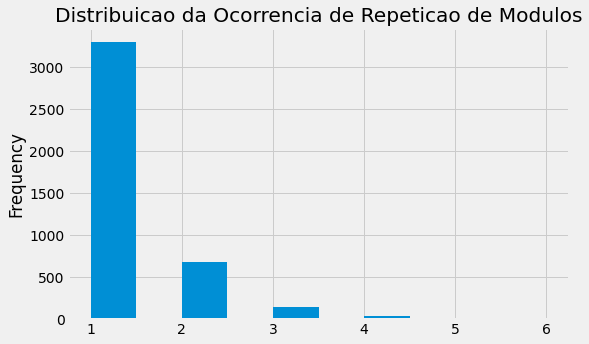

In [7]:
ax = (
       info.query("num_of_prev_attempts >=1")['num_of_prev_attempts']
       .plot(kind = 'hist')
     )

_= ax.set_title("Distribuicao da Ocorrencia de Repeticao de Modulos")
_= ax.set_xticks(np.arange(1,7))

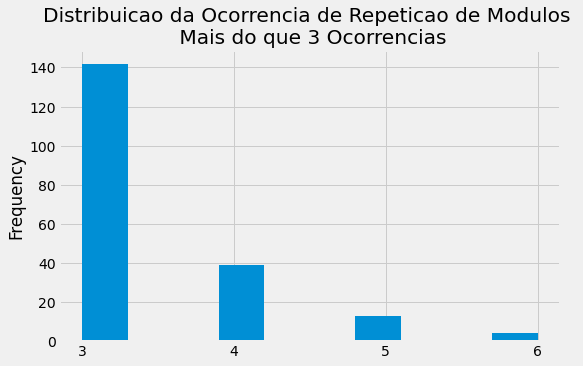

In [8]:
ax = (
       info.query("num_of_prev_attempts >=3")['num_of_prev_attempts']
       .plot(kind = 'hist')
     )

_= ax.set_title("Distribuicao da Ocorrencia de Repeticao de Modulos \n Mais do que 3 Ocorrencias")
_= ax.set_xticks(np.arange(3,7))

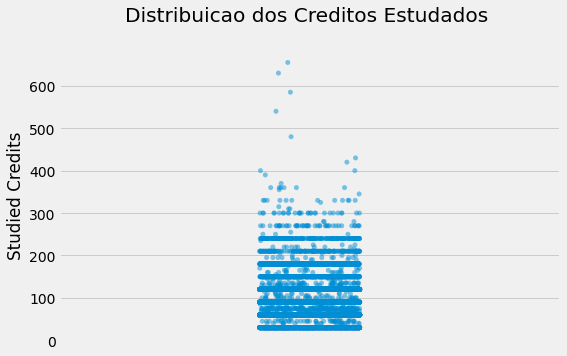

In [9]:
ax = sns.stripplot(y = info['studied_credits'],alpha = 0.5)
_= ax.set_ylabel("Studied Credits")
_= ax.set_title("Distribuicao dos Creditos Estudados \n")

Alguns pontos claramente destoantes (possivelmente *outliers*, pois muito fora da IQR), mas sem grande motivo para nos preocuparmos, pois utilizaremos Random Forests na primeira versão da solução, algoritmo que não impõem nenhuma hipótese quanto a distribuição dos atributos bem como bastante resistente a outliers.

In [10]:
duplicated_mask = info['id_student'].duplicated(keep = False)
info_duplicated = info[duplicated_mask]
info_duplicated.sort_values('id_student').head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
14395,DDD,2013J,8462,M,London Region,HE Qualification,30-40%,55<=,0,90,N,Withdrawn
17560,DDD,2014J,8462,M,London Region,HE Qualification,30-40%,55<=,1,60,N,Withdrawn
13091,DDD,2013B,24213,F,East Anglian Region,A Level or Equivalent,40-50%,0-35,0,90,N,Withdrawn
16332,DDD,2014B,24213,F,East Anglian Region,A Level or Equivalent,40-50%,0-35,1,60,N,Pass
2517,BBB,2013J,25629,F,Scotland,Lower Than A Level,20-30%,0-35,0,120,N,Withdrawn


In [11]:
f'{info_duplicated.query("num_of_prev_attempts >=1").shape[0]} estudantes repetiram modulos ao menos uma vez'

'1667 estudantes repetiram modulos ao menos uma vez'

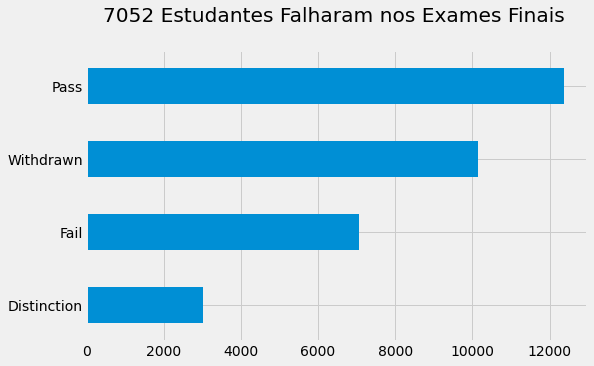

In [12]:
final_results = Counter(info['final_result'])
ax = (
       info
      .final_result
      .value_counts(ascending = True)
      .plot(kind = "barh")
     )

_= ax.set_ylabel("")
_= ax.set_title(str(final_results['Fail']) + ' Estudantes Falharam nos Exames Finais \n')

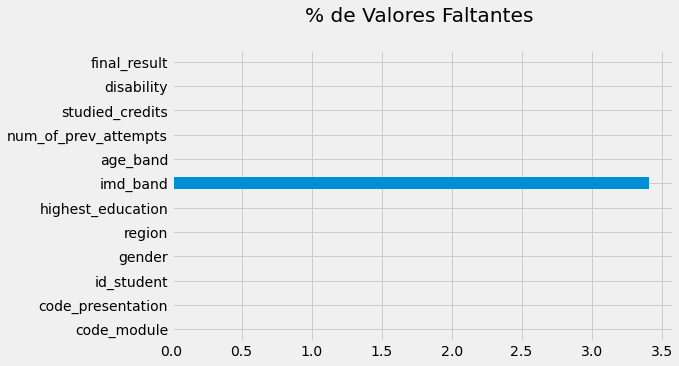

In [13]:
# Checando Valores Faltantes
ax = (
      info
     .isna()
     .mean()
     .mul(100)
     .plot(kind = "barh")
     )
_= ax.set_title("% de Valores Faltantes \n")

In [14]:
# Numero de Niveis Distintos das Variaveis Categoricas
categorical_cardinality(info)

{'code_module': 7,
 'code_presentation': 4,
 'gender': 2,
 'region': 13,
 'highest_education': 5,
 'imd_band': 10,
 'age_band': 3,
 'disability': 2,
 'final_result': 4}

Nenhuma variável com cardinalidade proibitivamente alta, o que resultara em mais opções para escolher o *encoding* a ser usado na modelagem. *One-hot-encoding* não sera caro computacionalmente e lida bem com categorias desconhecidas que podem aparecer em produção :)

## 1.2 Modelagem/Limpeza

A variável *code_presentation* nao sera útil com o *encoding* atual, pois saber o ano em que o aluno realizou o modulo nao seria relevante no momento da inferência. Contudo os códigos **J/B** tem valor, pois a época do ano em que o modulo foi cursado pode conter poder preditivo.

In [15]:
info_clean = (info
 .assign(module_code = lambda df_:df_['code_presentation']
         .str
         .split('([A-Z])',expand = True)[1])
             )

assert list(info_clean['module_code'].unique()) == ['J', 'B'] 

In [16]:
info_clean['module_code'].sample(5)

12323    J
11572    J
27533    B
23630    B
13721    B
Name: module_code, dtype: object

Para respondermos nossa questão de negocio (Quais estudantes falharão no Exame Final?), precisaremos reagrupar as categorias *Pass*/*Distinction* do alvo em Pass, alem de nao usarmos as observações em que os estudantes desistiram dos módulos (*Withdrawn*). Em experimentos futuros podemos rever essa hipotese e incorporar os dados coletados dos modulos em que o aluno desistiu.

In [17]:
# Primeira Tabela de Dados Feita :) 
feature_store = info_clean 

# Eliminadas as Observacoes em que o estudante desistiu e Alvo mapeado para (Pass/Fail)
data_first_experiment = (
                      feature_store
                      .query("final_result != 'Withdrawn'")
                      .pipe(get_target,target_name = 'final_result')
                      .drop(['id_student','code_presentation'],axis = 'columns')
                     )

assert list(data_first_experiment['final_result'].unique()) == ['Pass', 'Fail'] 

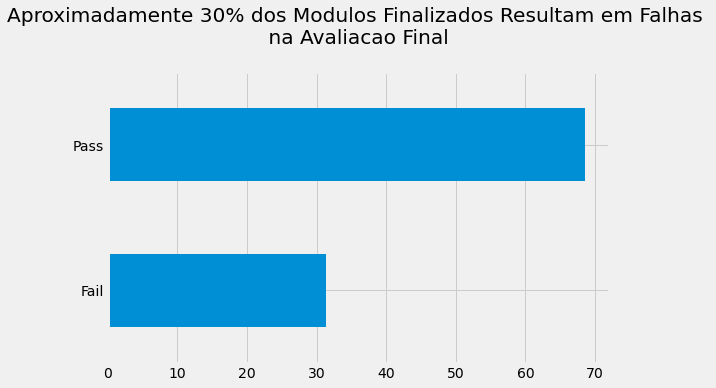

In [18]:
# Distribuicao do Alvo
ax = (
      data_first_experiment['final_result']
     .value_counts(normalize = True,ascending = True)
     .mul(100)
     .plot(kind = 'barh')
     )

_= ax.set_title("Aproximadamente 30% dos Modulos Finalizados Resultam em Falhas \n na Avaliacao Final \n")

*Dataset* levemente desbalanceado, o que nos obriga a usar algumas penalizações na função custo dos modelos (parâmetro *class weight*) de modo a dar oportunidade ao modelo de aprender melhor a classe *Fail*.Também precisamos estar atentos ao desbalaceamento no momento de dividir o *dataset* em partições de treino/teste de modo a preservar as proporções do alvo. O mesmo se aplica ao esquema de *Cross-Validation* que utilizaremos para avaliar o desempenho dos modelos. 

## 1.3 Avaliacao Preliminar do Poder Preditivo das Variáveis

In [19]:
categorical_cols = [col for col in data_first_experiment 
                    if data_first_experiment[col].dtype == 'object' and col != 'final_result']
categorical_cols

['code_module',
 'gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability',
 'module_code']

In [20]:
numerical_cols = [col for col in data_first_experiment if data_first_experiment[col].dtype != 'object']
numerical_cols

['num_of_prev_attempts', 'studied_credits']

In [21]:
assert ((len(categorical_cols) + len(numerical_cols))) == (data_first_experiment.shape[1] -1) 

Mapearemos o alvo como : 
- *Pass* --> 0
- *Fail* --> 1

In [22]:
data_first_experiment['final_result'] = (
                                            data_first_experiment['final_result']
                                             .map({'Pass':0,'Fail':1})
                                        )

Abaixo temos uma tabela para cada valor das variáveis categóricas mostrando a porcentagem de alunos que falham no exame final (*mean*) bem como a razão entre essa taxa e a porcentagem geral de alunos reprovados (*rate*).

Possíveis Valores de Rate:
- Maior que 1.0: Mais alunos do que a média geral reprovam para aquele nivel categórico.
- Menor que 1.0: Menos Alunos do que  a média geral reprovam para aquele nivel categórico.



In [23]:
categorical_mean(data_first_experiment,categorical_cols,'final_result')

,mean,rate
code_module,,
DDD,0.351069,1.116979
GGG,0.324710,1.033114
BBB,0.320051,1.018290
FFF,0.319276,1.015825
CCC,0.317609,1.010520
EEE,0.254069,0.808358
AAA,0.146302,0.465483


,mean,rate
gender,,
M,0.323556,1.029442
F,0.303264,0.964881


,mean,rate
region,,
Wales,0.396927,1.262883
North Western Region,0.376068,1.196518
London Region,0.353276,1.124002
Scotland,0.335565,1.067651
Yorkshire Region,0.332839,1.058978
West Midlands Region,0.330138,1.050383
East Midlands Region,0.299417,0.952639
East Anglian Region,0.299057,0.951496
Ireland,0.286498,0.911538


,mean,rate
highest_education,,
No Formal quals,0.479798,1.526550
Lower Than A Level,0.401265,1.276685
A Level or Equivalent,0.270295,0.859983
HE Qualification,0.229185,0.729186
Post Graduate Qualification,0.142259,0.452620


,mean,rate
imd_band,,
0-10%,0.440385,1.401150
10-20,0.401762,1.278267
20-30%,0.361766,1.151013
30-40%,0.320786,1.020628
50-60%,0.315056,1.002399
40-50%,0.314815,1.001631
70-80%,0.287704,0.915374
60-70%,0.262952,0.836622
80-90%,0.248994,0.792212


,mean,rate
age_band,,
0-35,0.336118,1.069409
35-55,0.266985,0.849451
55<=,0.179012,0.569555


,mean,rate
disability,,
Y,0.371027,1.180477
N,0.308997,0.983120


,mean,rate
module_code,,
B,0.360502,1.146991
J,0.285981,0.909893


Podemos verificar que para as diferentes categóricas tomadas isoladamente, ha um claro poder preditivo, pois os diferentes niveis mostram uma dispersão significativa de médias de reprovação. Ao analisarmos a variavel highest_education podemos ver claramente que estudantes sem educação formal (No Formal quals) possuem uma taxa de falha no exame final (~ 48%) muito maior do que os alunos com pos-graduação (~14%). Os módulos iniciados em outubro possuem taxa de reprovação de 28.6% enquanto os iniciados em fevereiro reprovam 36%. Muitos insights podem ser derivados dessas tabelas.

## 1.4 Partição dos Dados em Treino e Teste

Faremos uma partição nos dados em um grupo de treino e outro de teste. O grupo de treino sera utilizado para aprendermos os parâmetros do modelo bem como realizaremos um esquema de *cross-validation* para seleção dos melhores hiperparametros para avaliar eventuais melhorias de desempenho no modelo quando acrescentarmos mais atributos. O grupo de teste sera utilizado apenas uma única vez ao final de todos os experimentos para termos uma estimativa sem vies do desempenho do modelo a ser utilizado na solução do problema de negócio.

O esquema de *cross-validation* escolhido preserva a prevalência de estudantes que falham no exame final (~ 30%). Separaremos 10% das observações para o grupo de teste.

In [24]:
X = data_first_experiment.drop('final_result',axis = 'columns')
y = data_first_experiment['final_result']

assert X.shape[0] == y.shape[0]

In [25]:
X_train, _, y_train, _ = train_test_split(
                                         X,
                                         y,
                                         test_size = TEST_SIZE,
                                         random_state= RANDOM_SEED,
                                         stratify = y
                                        )

assert X_train.shape[0] == y_train.shape[0]

## 1.5 Pipeline de Transformações

Precisamos preparar nossos dados para usarmos a biblioteca Scikit-learn, pois esta trabalha apenas com *Numpy Arrays*.

In [26]:
# Transformacoes 
ohe = OneHotEncoder(handle_unknown = 'ignore') 
imputer_cat = SimpleImputer(strategy = 'constant',fill_value='Missing',add_indicator=True)
imputer_num = SimpleImputer(strategy = 'median',add_indicator=True)

In [27]:
# Pipeline
cat_pipeline = make_pipeline(imputer_cat,ohe)

In [28]:
first_experiment_pipeline = make_column_transformer(
                                                    (cat_pipeline,categorical_cols),
                                                    (imputer_num,numerical_cols)
                                                    )

first_experiment_pipeline

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['code_module', 'gender', 'region',
                                  'highest_education', 'imd_band', 'age_band',
                                  'disability', 'module_code']),
                                ('simpleimputer',
                                 SimpleImputer(add_indicator=True,
                                               strategy='median'),
                                 ['num_of_prev_attempts', 'studied_credits'])])

### 1.1.4 Classificador *Random Forest*

Selecionamos Random Forests como nosso classificador para os experimentos por algumas razoes:

- Modelo captura interações entre variáveis/nao-linearidades automaticamente.
- Nenhuma hipótese a respeito da distribuição dos dados precisa ser satisfeita.
- Treinamento do modelo escala bem com o número de observações.
- Pouca necessidade de tunning exaustivo de hiperparametros.
- Em geral tem desempenho bastante forte para produzir provas de conceito de soluções.

In [29]:
first_model = make_pipeline(
                            first_experiment_pipeline,
                            RandomForestClassifier(n_estimators=500,
                                                   max_features="sqrt",
                                                   class_weight='balanced',   #tentar remediar o desbalanceamento 
                                                   random_state=RANDOM_SEED)
                           )

first_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['code_module', 'gender',
                                                   'region',
                                                   'highest_education',
                                                   'imd_band', 'age_band',
                                                   'disability',
                                                   'module_code']),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'),
                                                  ['num_of_prev_attempts',
                                                   'studied_credits'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='sqrt', n_estimators=500,
                                        random_state=42))])

## 1.6 Métrica de Desempenho Selecionada

Nossa escolha para medir o desempenho do modelo sera *Average Precision Score*, que em termos mais leigos representa a area sob a curva *Precision-Recall*. Gostamos dessa métrica por sua bem-vinda propriedade de selecionar modelos com bom *rank* das predições. Essa propriedade nos abre a porta do ponto de vista da aplicação de fazer coisas como selecionar os estudantes com mais necessidade de intervenção antecipada em uma fila de pioridade. Esta métrica tem valores possíveis entre 0 e 1 (maior valor ---> melhor modelo).

## 1.7 Avaliando o Primeiro Modelo

In [30]:
skf = StratifiedKFold(n_splits=5,shuffle = True,random_state= RANDOM_SEED) # esquema de cross-validation
average_precision_first = cross_val_score(
                                            estimator = first_model,
                                            X = X_train,
                                            y = y_train,
                                            scoring = make_scorer(average_precision_score,needs_proba=True),
                                            cv = skf
                                             )
# Cross-Validation Predictions
cv_preds = cross_val_predict(
                              estimator = first_model,
                              X = X_train,
                              y = y_train,
                              cv = 5, # n_splits --> O padrao ja eh stratified kfold
                              method = 'predict_proba'
                             )

In [31]:
ap,std = np.mean(average_precision_first).round(2),np.std(average_precision_first).round(2)
f'CV Average Precision: {ap} / Desvio-Padrao: {std}'

'CV Average Precision: 0.39 / Desvio-Padrao: 0.01'

Para termos uma real noção do desempenho desse primeiro modelo, faremos uma comparação com um modelo usando a simples heurística de classificar todas as observações como *Fail*.

In [32]:
naive_model = DummyClassifier(strategy = 'most_frequent')
average_precision_naive = cross_val_score(
                                            estimator = naive_model,
                                            X = X_train,
                                            y = y_train,
                                            scoring = make_scorer(average_precision_score,needs_proba=True),
                                            cv = skf
                                             )

In [33]:
ap,std = np.mean(average_precision_naive).round(2),np.std(average_precision_naive).round(2)
f'CV Average Precision: {ap} / Desvio-Padrao: {std}'

'CV Average Precision: 0.31 / Desvio-Padrao: 0.0'

Nosso primeiro modelo tem desempenho 26% superior a uma heurística simples. Bom começo, dado que este primeiro experimento apenas leva em conta o histórico dos alunos antes de interagirem com os cursos. Um possível uso desse modelo seria identificar alunos que o modelo classificar como de alta probabilidade de falharem no exame final logo apos a matrícula e articular acoes (acompanhamento mais próximo com tutor, reuniões, etc.). Algumas variáveis me preocupam um pouco do ponto de vista de discriminação algorítmica, como sexo, região de moradia e proxies de renda como imd. Mas neste momento seguiremos experimentando para obtermos uma prova de conceito no menor tempo possível. Fica a nota de atenção.

## 1.8 Salvando o Primeiro Experimento em Disco

In [34]:
first_model.fit(X_train,y_train)
dump(first_model, 'primeiro_experimento.joblib')
assert (load('primeiro_experimento.joblib').predict(X_train) == first_model.predict(X_train)).all()

# 2. Segundo Experimento

## 2.1 Exploração/Agregação de  StudentAssessment e Assessments

No segundo experimento iremos testar se agregar as notas de avaliações contidas nos datasets studentAssessment e assessments ira melhorar o desempenho do modelo. Intuitivamente esperamos um grande aumento de desempenho, dado que inuitivamente notas em avaliações preliminares sao fortemente correlacionadas com a nota final. Os passos seguidos no primeiro experimento serão replicados.

In [35]:
student_assessment = pd.read_csv(Path(input_folder,studentAssessment_data),low_memory=False)

In [36]:
f'Student Assessment Dataset Contem {student_assessment.shape[0]} linhas e {student_assessment.shape[1]} colunas'

'Student Assessment Dataset Contem 173912 linhas e 5 colunas'

In [37]:
student_assessment.head(5)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [38]:
student_assessment.describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,173912.000000,1.739120e+05,173912.000000,173912.000000,173739.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977,75.799573
std,8829.784254,5.523952e+05,71.484148,0.104194,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


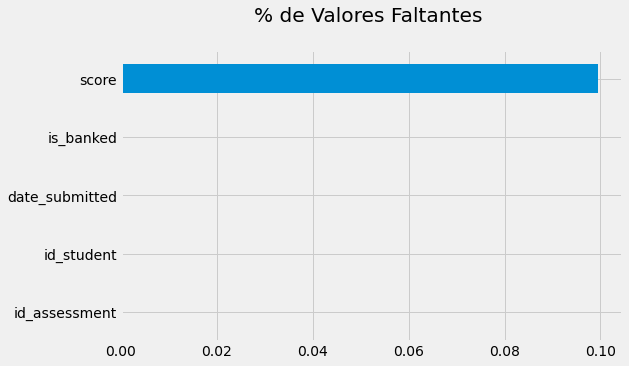

In [39]:
ax = (
    student_assessment
    .isna()
    .mean()
    .mul(100)
    .plot(kind = 'barh'))

_= ax.set_title("% de Valores Faltantes \n")

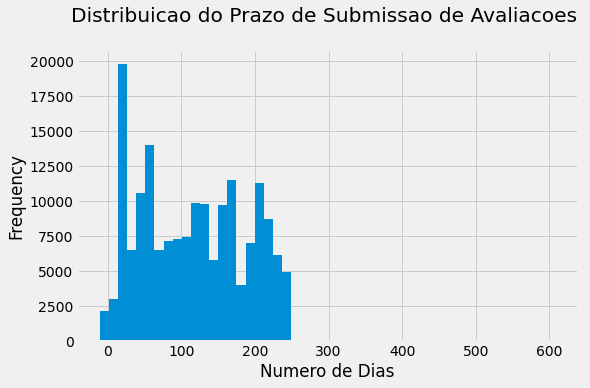

In [40]:
ax = student_assessment['date_submitted'].plot(kind = 'hist',bins = 50)
_= ax.set_title("Distribuicao do Prazo de Submissao de Avaliacoes \n")
_= ax.set_xlabel("Numero de Dias")

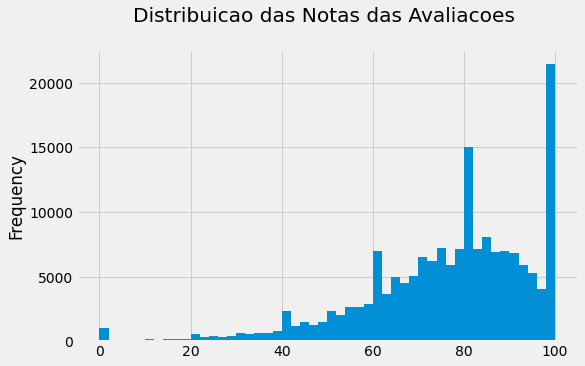

In [41]:
ax = student_assessment['score'].plot(kind = 'hist',bins = 50)
_= ax.set_title("Distribuicao das Notas das Avaliacoes \n")
_= ax.set_xlabel("")

Alguns *clusters* apareceram na distribuição das notas (40,60,80,100). Provavelmente alguns tipos de avaliações aplicam notas discretas/conceitos.

In [42]:
student_assessment[['date_submitted','score']].corr('spearman')

,date_submitted,score
date_submitted,1.000000,-0.040422
score,-0.040422,1.000000


Esperava uma *rank correlation* bastante maior entre o desempenho nas avaliações e o prazo de submissão.

In [43]:
assessments = pd.read_csv(Path(input_folder,assessments_data),low_memory=False)

In [44]:
f'assessments Dataset Contem {assessments.shape[0]} linhas e {assessments.shape[1]} colunas'

'assessments Dataset Contem 206 linhas e 6 colunas'

In [45]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


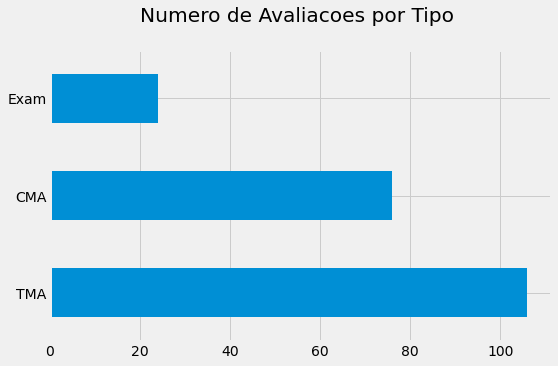

In [46]:
ax = (
      assessments['assessment_type']
      .value_counts()
      .plot(kind = 'barh')
     )

_= ax.set_title("Numero de Avaliacoes por Tipo \n")

In [47]:
assessments.query("assessment_type == 'Exam'")['weight'].describe()

count     24.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: weight, dtype: float64

Avaliacao final com peso 100.0, como esperado. 

Vamos agregar os datasets *studentAssessment* e *assessments* via a chave *id_student* antes de eventualmente gerarmos novos atributos e limpar os dados.

In [48]:
assessment_agg = pd.merge(student_assessment,assessments,on='id_assessment')
assessment_agg.sort_values(by=['id_student']).tail()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
43599,15022,2698588,109,0,87.0,BBB,2014J,TMA,110.0,20.0
44183,15023,2698588,152,0,95.0,BBB,2014J,TMA,152.0,35.0
41825,15021,2698588,53,0,85.0,BBB,2014J,TMA,54.0,10.0
39567,15020,2698588,18,0,100.0,BBB,2014J,TMA,19.0,0.0
45940,15024,2698588,202,0,95.0,BBB,2014J,TMA,201.0,35.0


Queremos calcular um score medio ponderado pelos pesos de cada tipo avaliação e adiciona-los como variáveis do modelo. Com isso capturamos o desempenho de acordo com a importância de cada avaliação.

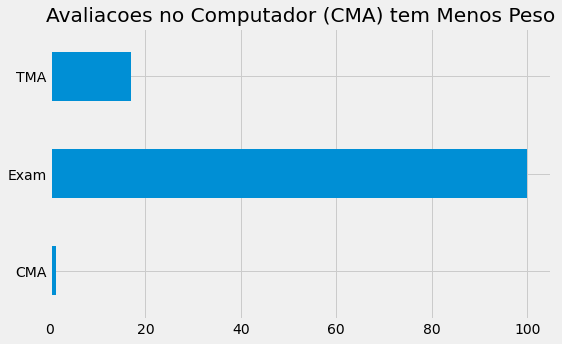

In [49]:
ax = (
       assessments
       .groupby('assessment_type')['weight']
       .mean()
       .plot(kind = 'barh')
      )


_= ax.set_title("Avaliacoes no Computador (CMA) tem Menos Peso")
_= ax.set_ylabel("")
_= ax.set_label("Peso %")

In [50]:
assessment_agg['score_weighted'] = assessment_agg['score']*assessment_agg['weight']

assessment_agg = (
                  assessment_agg
                 .groupby(['id_student', 'code_module', 'code_presentation', 'assessment_type'])['score_weighted']
                 .sum()
                 .divide(100)
                 .reset_index()
                 )


assert assessment_agg.query('id_student == 6516')['score_weighted'][0] == 63.5 # Valor Calculado Manualmente :)

In [51]:
assessment_agg.sort_values('id_student').tail()

,id_student,code_module,code_presentation,assessment_type,score_weighted
44875,2698535,CCC,2014B,TMA,5.06
44874,2698535,CCC,2014B,CMA,4.31
44876,2698535,EEE,2013J,TMA,53.44
44877,2698577,BBB,2014J,TMA,55.80
44878,2698588,BBB,2014J,TMA,92.40


A tabela *assessment_agg* ainda nao esta pronta para ser agregada a *feature_store*, pois cada observacao precisa ser unica para a tupla ('id_student', 'code_module', 'code_presentation').

In [52]:
assessment_agg = (
                  assessment_agg
                 .set_index(['id_student', 'code_module', 'code_presentation'])
                 .pivot(columns="assessment_type")['score_weighted']
                 .reset_index()
                 .rename_axis(None, axis = 'columns')
                 .drop('Exam',axis = 'columns')  # No momento da predicao nao temos informacao sobre o Exame. 
                 )

In [53]:
assessment_agg.sort_values('id_student').head()

,id_student,code_module,code_presentation,CMA,TMA
0,6516,AAA,2014J,NaN,63.50
1,8462,DDD,2013J,NaN,34.90
2,8462,DDD,2014J,NaN,43.00
3,11391,AAA,2013J,NaN,82.40
4,23629,BBB,2013B,2.0,14.69


Adicionando as novas colunas na nossa *feature store*.

In [54]:
feature_store = pd.merge(feature_store, assessment_agg, on=['id_student', 'code_module', 'code_presentation'])

In [55]:
feature_store.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_code,CMA,TMA
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,J,NaN,82.4
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,J,NaN,65.4
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,J,NaN,76.3
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,J,NaN,55.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,J,NaN,66.9


## 2.2 Limpeza dos Dados

In [56]:
# Eliminadas as Observacoes em que o estudante desistiu e Alvo mapeado para (Pass/Fail)
data_second_experiment = (
                      feature_store
                      .query("final_result != 'Withdrawn'")
                      .pipe(get_target,target_name = 'final_result')
                      .drop(['id_student','code_presentation'],axis = 'columns')
                     )

assert list(data_second_experiment['final_result'].unique()) == ['Pass', 'Fail'] 

In [57]:
data_second_experiment.head()

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_code,CMA,TMA
0,AAA,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,J,NaN,82.4
1,AAA,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,J,NaN,65.4
2,AAA,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,J,NaN,76.3
3,AAA,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,J,NaN,55.0
4,AAA,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,J,NaN,66.9


In [58]:
categorical_cols = [col for col in data_second_experiment 
                    if data_second_experiment[col].dtype == 'object' and col != 'final_result']
categorical_cols

['code_module',
 'gender',
 'region',
 'highest_education',
 'imd_band',
 'age_band',
 'disability',
 'module_code']

In [59]:
numerical_cols = [col for col in data_second_experiment if data_second_experiment[col].dtype != 'object' 
                  and col not in ['CMA','TMA'] ]
numerical_cols

['num_of_prev_attempts', 'studied_credits']

In [60]:
grade_cols = ['CMA','TMA']

In [61]:
assert ((len(categorical_cols) + len(numerical_cols) + len(grade_cols))) == (data_second_experiment.shape[1] - 1) 

In [62]:
data_second_experiment['final_result'] = (
                                            data_second_experiment['final_result']
                                            .map({'Pass':0,'Fail':1})
                                        )

In [63]:
data_second_experiment.head()

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_code,CMA,TMA
0,AAA,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,0,J,NaN,82.4
1,AAA,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,0,J,NaN,65.4
2,AAA,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,0,J,NaN,76.3
3,AAA,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,0,J,NaN,55.0
4,AAA,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,0,J,NaN,66.9


## 2.3 Partição dos Dados em Treino e Teste

In [64]:
X = data_second_experiment.drop('final_result',axis = 'columns')
y = data_second_experiment['final_result']

assert X.shape[0] == y.shape[0]

X_train, _, y_train, _ = train_test_split(
                                         X,
                                         y,
                                         test_size = TEST_SIZE,
                                         random_state= RANDOM_SEED,
                                         stratify = y
                                        )

assert X_train.shape[0] == y_train.shape[0]

## 2.4 Segundo Modelo

Valores faltantes nas avaliações (CMA,TMA) serao imputadas com valor zero.

In [65]:
imputer_grades = SimpleImputer(strategy = 'constant',fill_value = 0,add_indicator=True)

In [66]:
second_experiment_pipeline = make_column_transformer(
                                                    (cat_pipeline,categorical_cols),
                                                    (imputer_num,numerical_cols),
                                                    (imputer_grades,grade_cols)
                                                    )

second_experiment_pipeline

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['code_module', 'gender', 'region',
                                  'highest_education', 'imd_band', 'age_band',
                                  'disability', 'module_code']),
                                ('simpleimputer-1',
                                 SimpleImputer(add_indicator=True,
                                               strategy='median'),
                                 ['num_of_prev_attempts', 'studied_credits']),
                                ('simpleimputer-2',
                                 SimpleImputer(add_indicator=True, fill_value=0,
                                               strategy='constant'),
                                 ['CMA', 'TMA'])])

In [67]:
second_model = make_pipeline(
                            second_experiment_pipeline,
                            RandomForestClassifier(n_estimators=500,
                                                   max_features="sqrt",
                                                   class_weight='balanced',   #remediar o desbalanceamento 
                                                   random_state=RANDOM_SEED)
                           )

second_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['code_module', 'gender',
                                                   'region',
                                                   'highest_education',
                                                   'imd_band', 'age_band',
                                                   'disability',
                                                   'module_code']),
                                                 ('simpleimputer-1',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'),
                                                  ['num_of_prev_attempts',
                                                   'studied_credits']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=0,
                                                                strategy='constant'),
                                                  ['CMA', 'TMA'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='sqrt', n_estimators=500,
                                        random_state=42))])

## 2.5 Avaliando o Segundo Modelo

In [68]:
average_precision_second = cross_val_score(
                                            estimator = second_model,
                                            X = X_train,
                                            y = y_train,
                                            scoring = make_scorer(average_precision_score,needs_proba=True),
                                            cv = skf
                                             )
# Cross-Validation Predictions
cv_preds = cross_val_predict(
                              estimator = second_model,
                              X = X_train,
                              y = y_train,
                              cv = 5, # n_splits --> O padrao ja eh stratified kfold
                              method = 'predict_proba'
                             )

In [69]:
ap,std = np.mean(average_precision_second).round(2),np.std(average_precision_second).round(3)
f'CV Average Precision: {ap} / Desvio-Padrão: {std}'

'CV Average Precision: 0.86 / Desvio-Padrão: 0.005'

Wow! O segundo experimento produziu um modelo **120%** mais capaz do que o primeiro. *Average Precision* saltou para **0.86** e com estabilidade na *Cross-Validation* (desvio-padrão bastante baixo), o que nos da confiança sobre a qualidade do modelo produzido. Como temos ainda um pouco de orçamento de horas, faremos um terceiro experimento.

## 2.6 Salvando o Segundo Experimento em Disco

In [70]:
second_model.fit(X_train,y_train)
dump(second_model, 'segundo_experimento.joblib')
assert (load('segundo_experimento.joblib').predict(X_train) == second_model.predict(X_train)).all()

# 3. Terceiro Experimento

## 3.1 Exploração/Agregação de studentVle e Vle

No terceiro experimento iremos agregar os dados sobre a interação dos estudantes na plataforma de aprendizagem, como clicks nas diversas atividades dos módulos (ou a ausência de interação). Nossa intuição diz que este experimento pode levar o desempenho do modelo mais longe ainda.

In [71]:
student_Vle = pd.read_csv(Path(input_folder,studentVle_data))  #Dataset Grande --> low_memory mudado pra True

In [72]:
f'Student_Vle Assessment Dataset Contem {student_Vle.shape[0]} linhas e {student_Vle.shape[1]} colunas'

'Student_Vle Assessment Dataset Contem 10655280 linhas e 6 colunas'

In [73]:
student_Vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [74]:
student_Vle[['date','sum_click']].describe()

,date,sum_click
count,1.065528e+07,1.065528e+07
mean,9.517400e+01,3.716946e+00
std,7.607130e+01,8.849047e+00
min,-2.500000e+01,1.000000e+00
25%,2.500000e+01,1.000000e+00
50%,8.600000e+01,2.000000e+00
75%,1.560000e+02,3.000000e+00
max,2.690000e+02,6.977000e+03


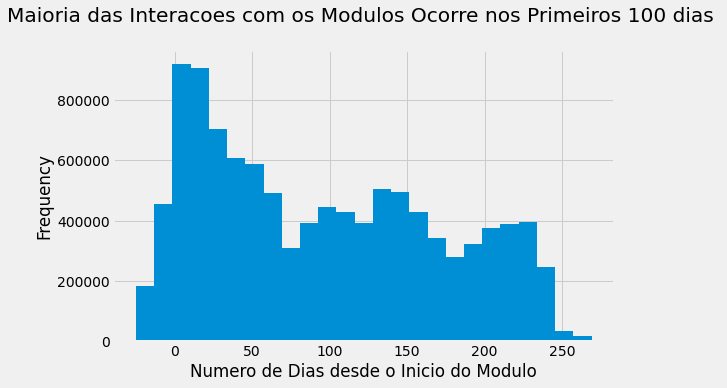

In [75]:
ax = (
      student_Vle['date']
      .plot(kind = 'hist',bins = 25)
     )

_= ax.set_title("Maioria das Interacoes com os Modulos Ocorre nos Primeiros 100 dias \n")
_= ax.set_xlabel("Numero de Dias desde o Inicio do Modulo")

In [76]:
student_Vle['sum_click'].quantile(q = 0.99)

34.0

O quantile de 99% mostra 34 interacoes com o material por dia, o que nos leva a crer que o valor de 6.977000e+03 clicks que aparece no sumario dos dados acima eh um *outlier* massivo. Neste experimento nao lidaremos com isso ainda. Veremos como o modelo lida com isso.

In [77]:
(
    student_Vle
    .isna()
    .mean()
)

code_module          0.0
code_presentation    0.0
id_student           0.0
id_site              0.0
date                 0.0
sum_click            0.0
dtype: float64

*Dataset* sem valores faltantes.

In [78]:
vle = pd.read_csv(Path(input_folder,vle_data))

In [79]:
f'vle Dataset Contem {vle.shape[0]} linhas e {vle.shape[1]} colunas'

'vle Dataset Contem 6364 linhas e 6 colunas'

In [80]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


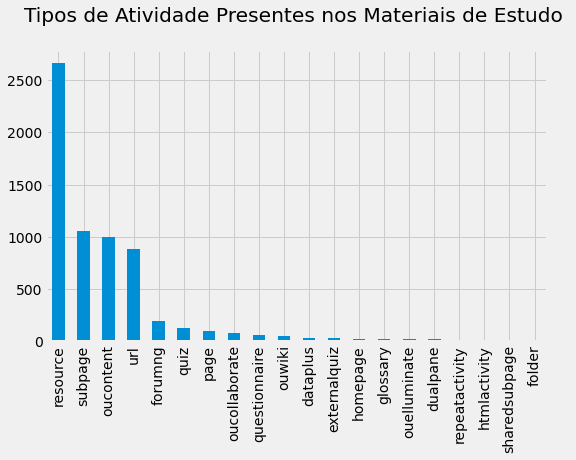

In [81]:
ax = (
       vle['activity_type']
       .value_counts()
       .plot(kind = 'bar')
)

_= ax.set_title("Tipos de Atividade Presentes nos Materiais de Estudo \n")

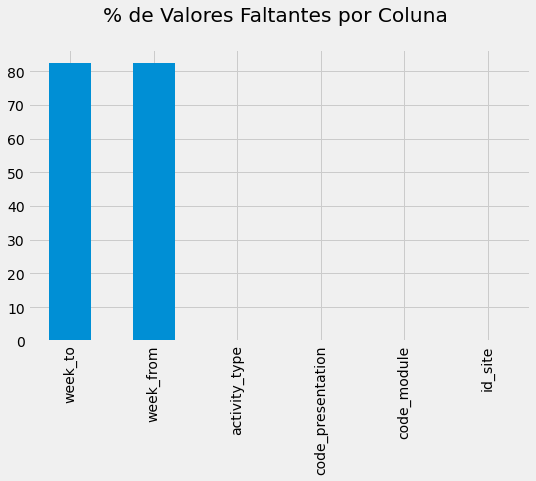

In [82]:
ax = (
        vle
       .isna()
       .mean()
       .sort_values(ascending = False)
       .mul(100)
       .plot(kind = 'bar')
)

_= ax.set_title("% de Valores Faltantes por Coluna \n")

As colunas *week_to* e *week_from* serao ignoradas neste experimento pois contem mais de 80% de valores faltantes. O poder preditivo delas provavelmente sera baixo. Tambem nao precisamos das colunas *code_module* e *code_presentation*, presentes no dataset *studentVle*. 

In [83]:
vle.drop(['code_module','code_presentation','week_from','week_to'],axis = 1,inplace = True)
vle.head()

,id_site,activity_type
0,546943,resource
1,546712,oucontent
2,546998,resource
3,546888,url
4,547035,resource


Atraves da chave *id_site* podemos agregar os datasets *student_Vle* e *vle*.

In [84]:
vle_agg = student_Vle.merge(vle, on='id_site')

Para nao termos mais problemas de memoria :( , vamos deletar o gigante dataframe *student_Vle*.

In [85]:
del student_Vle # ufa! 

In [86]:
vle_agg.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type
0,AAA,2013J,28400,546652,-10,4,forumng
1,AAA,2013J,28400,546652,-10,1,forumng
2,AAA,2013J,28400,546652,-10,1,forumng
3,AAA,2013J,28400,546652,-10,8,forumng
4,AAA,2013J,30268,546652,-10,3,forumng


Derivaremos uma coluna agregando os clicks de cada aluno para cada modulo,apresentacao e tipo de atividade estudada.

In [87]:
total_clicks = (
                vle_agg.groupby(['id_student', 
                                           'code_module', 
                                           'code_presentation', 
                                           'activity_type'])['sum_click']
                                           .sum()
                                           .reset_index()
                )

In [88]:
total_clicks.head()

,id_student,code_module,code_presentation,activity_type,sum_click
0,6516,AAA,2014J,dataplus,21
1,6516,AAA,2014J,forumng,451
2,6516,AAA,2014J,homepage,497
3,6516,AAA,2014J,oucontent,1505
4,6516,AAA,2014J,resource,31


A tabela *total_clicks* ainda nao esta pronta para ser agregada a *feature_store*, pois cada observacao precisa ser unica para a tupla ('id_student', 'code_module', 'code_presentation').

In [89]:
total_clicks = (
                 total_clicks
                 .set_index(['id_student', 'code_module', 'code_presentation'])
                 .pivot(columns="activity_type")['sum_click']
                 .reset_index()
                 .rename_axis(None, axis=1)
                )

In [90]:
total_clicks.head()

,id_student,code_module,code_presentation,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,6516,AAA,2014J,21.0,NaN,NaN,NaN,451.0,NaN,497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,143.0,143.0
1,8462,DDD,2013J,NaN,NaN,12.0,NaN,36.0,NaN,184.0,...,NaN,18.0,NaN,NaN,NaN,NaN,70.0,NaN,227.0,23.0
2,8462,DDD,2014J,NaN,NaN,NaN,NaN,2.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11391,AAA,2013J,NaN,NaN,NaN,NaN,193.0,NaN,138.0,...,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,32.0,5.0
4,23629,BBB,2013B,NaN,NaN,NaN,NaN,87.0,NaN,36.0,...,NaN,NaN,NaN,NaN,31.0,NaN,2.0,NaN,5.0,NaN


Adicionando as novas colunas na nossa *feature store*.

In [91]:
feature_store = pd.merge(feature_store, total_clicks, on=['id_student', 'code_module', 'code_presentation'])

In [92]:
feature_store.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,32.0,5.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,87.0,48.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,144.0,90.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,79.0,14.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,...,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,91.0,45.0


## 3.2 Limpeza dos Dados

In [93]:
# Eliminadas as Observacoes em que o estudante desistiu e Alvo mapeado para (Pass/Fail)
data_third_experiment = (
                       feature_store
                      .query("final_result != 'Withdrawn'")
                      .pipe(get_target,target_name = 'final_result')
                      .drop(['id_student','code_presentation'],axis = 'columns')
                     )

assert list(data_third_experiment['final_result'].unique()) == ['Pass', 'Fail'] 

In [94]:
data_third_experiment.head()

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,AAA,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,32.0,5.0
1,AAA,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,87.0,48.0
2,AAA,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,144.0,90.0
3,AAA,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,79.0,14.0
4,AAA,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,91.0,45.0


In [95]:
numerical_cols = [col for col in data_third_experiment if data_third_experiment[col].dtype != 'object' 
                  and col not in ['CMA','TMA'] ]
numerical_cols

['num_of_prev_attempts',
 'studied_credits',
 'dataplus',
 'dualpane',
 'externalquiz',
 'folder',
 'forumng',
 'glossary',
 'homepage',
 'htmlactivity',
 'oucollaborate',
 'oucontent',
 'ouelluminate',
 'ouwiki',
 'page',
 'questionnaire',
 'quiz',
 'repeatactivity',
 'resource',
 'sharedsubpage',
 'subpage',
 'url']

In [96]:
assert ((len(categorical_cols) + len(numerical_cols) + len(grade_cols))) == (data_third_experiment.shape[1] - 1) 

In [97]:
data_third_experiment['final_result'] = (
                                            data_third_experiment['final_result']
                                            .map({'Pass':0,'Fail':1})
                                        )

## 3.3 Partição dos Dados em Treino e Teste

In [98]:
X = data_third_experiment.drop('final_result',axis = 'columns')
y = data_third_experiment['final_result']

assert X.shape[0] == y.shape[0]

X_train, X_test, y_train, y_test = train_test_split(
                                         X,
                                         y,
                                         test_size = TEST_SIZE,
                                         random_state= RANDOM_SEED,
                                         stratify = y
                                        )

assert X_train.shape[0] == y_train.shape[0]

## 3.4 Terceiro Modelo

Valores faltantes nos clicks das atividades serao imputados com valor zero.

In [99]:
third_experiment_pipeline = make_column_transformer(
                                                    (cat_pipeline,categorical_cols),
                                                    (imputer_num,numerical_cols),
                                                    (imputer_grades,grade_cols),
                                                    )

third_experiment_pipeline

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['code_module', 'gender', 'region',
                                  'highest_education', 'imd_band', 'age_band',
                                  'disability', 'module_code']),
                                ('simpleimputer-1',
                                 SimpleImputer(a...
                                 ['num_of_prev_attempts', 'studied_credits',
                                  'dataplus', 'dualpane', 'externalquiz',
                                  'folder', 'forumng', 'glossary', 'homepage',
                                  'htmlactivity', 'oucollaborate', 'oucontent',
                                  'ouelluminate', 'ouwiki', 'page',
                                  'questionnaire', 'quiz', 'repeatactivity',
                                  'resource', 'sharedsubpage', 'subpage',
                                  'url']),
                                ('simpleimputer-2',
                                 SimpleImputer(add_indicator=True, fill_value=0,
                                               strategy='constant'),
                                 ['CMA', 'TMA'])])

In [100]:
third_model = make_pipeline(
                            third_experiment_pipeline,
                            RandomForestClassifier(n_estimators=500,
                                                   max_features="sqrt",
                                                   class_weight='balanced',   #remediar o desbalanceamento 
                                                   random_state=RANDOM_SEED)
                           )
third_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['code_module', 'gender',
                                                   'region',
                                                   'highest_education',
                                                   'imd_band', 'age_band',
                                                   'disability',
                                                   'module_code'...
                                                   'oucollaborate', 'oucontent',
                                                   'ouelluminate', 'ouwiki',
                                                   'page', 'questionnaire',
                                                   'quiz', 'repeatactivity',
                                                   'resource', 'sharedsubpage',
                                                   'subpage', 'url']),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value=0,
                                                                strategy='constant'),
                                                  ['CMA', 'TMA'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='sqrt', n_estimators=500,
                                        random_state=42))])

## 3.5 Avaliando o Terceiro Modelo

In [101]:
average_precision_third = cross_val_score(
                                            estimator = third_model,
                                            X = X_train,
                                            y = y_train,
                                            scoring = make_scorer(average_precision_score,needs_proba=True),
                                            cv = skf
                                             )
# Cross-Validation Predictions
cv_preds = cross_val_predict(
                              estimator = third_model,
                              X = X_train,
                              y = y_train,
                              cv = 5, # n_splits --> O padrao ja eh stratified kfold
                              method = 'predict_proba'
                             )

In [102]:
ap,std = np.mean(average_precision_third).round(2),np.std(average_precision_third).round(3)
f'CV Average Precision: {ap} / Desvio-Padrão: {std}'

'CV Average Precision: 0.89 / Desvio-Padrão: 0.004'

O modelo avançou **3.4%** sobre o segundo experimento. O esquema de *cross-validation* nos indica *Average Precision* estavel em **0.89**. Ha espaço para mais experimentos no futuro, mas nosso orçamento de horas esta terminando e julgo termos um modelo forte o suficiente para atacarmos o problema de negócio.

## 3.6 Busca por Hiperparametros Ótimos

Agora faremos uma busca por alguma configuração de hiperparametros que nos ajude a melhorar ainda mais o desempenho do modelo.

Construiremos um dicionário com os hiperparametros que desejamos otimizar. Nao sera uma busca exaustiva, pois sabemos que *Random Forests* tem desempenho forte com os hiperparametros de prateleira. Podemos fazer isso apos discutir a aplicação do modelo na solução do problema.

In [103]:
params = {}
params['randomforestclassifier__max_features'] = ["sqrt",0.6,0.8]
params['randomforestclassifier__max_depth'] = [None,15,25]
params['randomforestclassifier__n_estimators'] = [100,500]
params

{'randomforestclassifier__max_features': ['sqrt', 0.6, 0.8],
 'randomforestclassifier__max_depth': [None, 15, 25],
 'randomforestclassifier__n_estimators': [100, 500]}

In [104]:
grid = GridSearchCV(
                    third_model, 
                    param_grid=params,
                    scoring = make_scorer(average_precision_score,needs_proba=True), 
                    cv=skf,
                    verbose = 100,
                    return_train_score=True,
                    n_jobs = -1
                    )

grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   4

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        fill_value='Missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['code_module',
                                                                          'ge...
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_features='sqrt',
                                                               n_estimators=500,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 15, 25],
                         'randomforestclassifier__max_features': ['sqrt', 0.6,
                                                                  0.8],
                         'randomforestclassifier__n_estimators': [100, 500]},
             return_train_score=True,
             scoring=make_scorer(average_precision_score, needs_proba=True),
             verbose=1000)

In [105]:
grid_search = pd.DataFrame(grid.cv_results_)
grid_search.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__max_features,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
9,94.598645,1.218520,0.725208,0.132557,15,0.6,500,"{'randomforestclassifier__max_depth': 15, 'ran...",0.894049,0.886182,...,0.892856,0.003414,1,0.999540,0.999339,0.999483,0.999275,0.999603,0.999448,1.228775e-04
15,100.555753,1.708224,0.706482,0.137758,25,0.6,500,"{'randomforestclassifier__max_depth': 25, 'ran...",0.893216,0.885555,...,0.892252,0.003476,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
3,98.443102,0.684933,0.558761,0.014608,None,0.6,500,"{'randomforestclassifier__max_depth': None, 'r...",0.892522,0.886092,...,0.892035,0.003077,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
11,126.404392,1.473534,0.749426,0.124062,15,0.8,500,"{'randomforestclassifier__max_depth': 15, 'ran...",0.892356,0.884686,...,0.891315,0.003442,4,0.999364,0.998896,0.999153,0.998811,0.999284,0.999102,2.149769e-04
17,97.625056,4.550228,0.337384,0.043638,25,0.8,500,"{'randomforestclassifier__max_depth': 25, 'ran...",0.891456,0.884501,...,0.891243,0.003636,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
8,19.194906,0.749164,0.149683,0.033427,15,0.6,100,"{'randomforestclassifier__max_depth': 15, 'ran...",0.891123,0.885203,...,0.890991,0.003008,6,0.999299,0.999175,0.999289,0.998981,0.999339,0.999217,1.296828e-04
5,136.518155,0.919352,0.672800,0.153161,None,0.8,500,"{'randomforestclassifier__max_depth': None, 'r...",0.890760,0.884214,...,0.890770,0.003574,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
1,24.681021,0.118192,0.801627,0.141238,None,sqrt,500,"{'randomforestclassifier__max_depth': None, 'r...",0.889898,0.885477,...,0.890707,0.004325,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
13,24.309819,0.387382,0.911642,0.193252,25,sqrt,500,"{'randomforestclassifier__max_depth': 25, 'ran...",0.889187,0.885007,...,0.890367,0.004559,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00
10,25.197613,0.478008,0.174694,0.033528,15,0.8,100,"{'randomforestclassifier__max_depth': 15, 'ran...",0.890965,0.884091,...,0.890102,0.003291,10,0.999208,0.998598,0.998999,0.998646,0.998969,0.998884,2.298442e-04


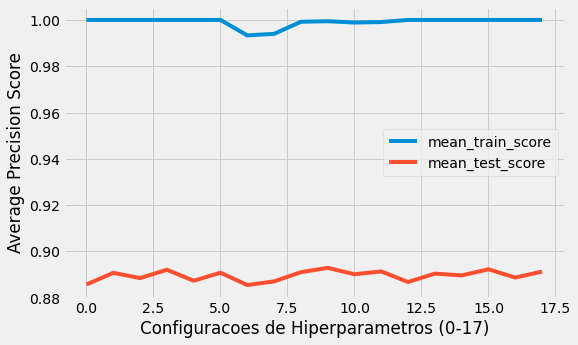

In [106]:
ax = grid_search[['mean_train_score','mean_test_score']].plot()
_= ax.set_xlabel("Configuracoes de Hiperparametros (0-17)")
_= ax.set_ylabel("Average Precision Score")

Ao analisar as tabelas e o gráfico acima, podemos concluir:


 - Há overfitting, portanto talvez regularizar ajude o modelo a ter melhor desempenho num próximo experimento.
 - O desempenho no esquema de *Cross Validation* esta em torno de **0.89**
 - Escolheremos o modelo de *rank* 7 na busca de hiperparametros por ter desempenho parecido aos *ranks* superiores, mas usando menos árvores e tendo uma profundidade limitada a 15 níveis pode ser treinado mais rápido produz predições significativamente mais rápido (fator de 5x).

rf_estimator = RandomForestClassifier(
                                       n_estimators=100,
                                       max_features=0.6,
                                       max_depth=15
                                      )
rf_estimator.fit(third_experiment_pipeline.fit_transform(X_train),y_train)

# 4. Desempenho do Modelo

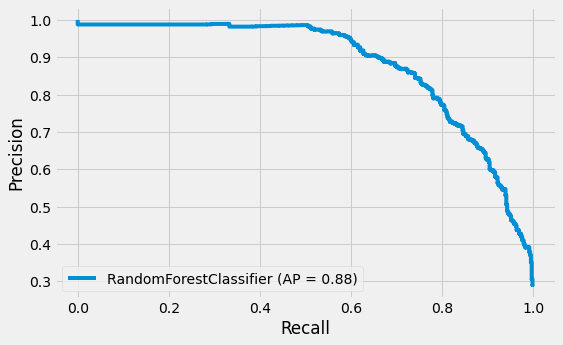

In [115]:
X_test = third_experiment_pipeline.transform(X_test)
ax = plot_precision_recall_curve(rf_estimator,X_test,y_test)

A estimativa de desempenho do modelo via *Cross-Validation* provou-se boa, dada a pequena diferenca entre *Average Precision* estimada (0.89) e a estimada nos dados de teste (**0.88**).

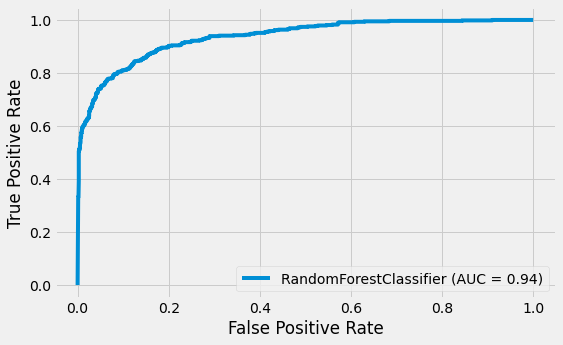

In [126]:
ax = plot_roc_curve(rf_estimator,X_test,y_test)

O modelo apresenta excelente desempenho para discriminar as classes, dado seu alto valor de AUC (**0.94**). 

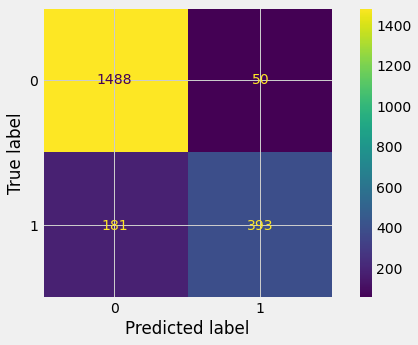

In [122]:
ax = plot_confusion_matrix(rf_estimator,X_test,y_test)

In [131]:
f'Dos {y_test.sum()} alunos reprovados nos dados de teste, o modelo foi capaz de identificar 393 destes.'

'Dos 574 alunos reprovados nos dados de teste, o modelo foi capaz de identificar 393 destes.'

In [135]:
f'Dos {y_test.shape[0] - y_test.sum()} alunos aprovados, o modelo foi capaz de identificar 1488 destes.'

'Dos 1538 alunos aprovados, o modelo foi capaz de identificar 1488 destes.'

O modelo em seu estado atual demonstrou excelente potencial para ser aplicado na solucao do problema de predizer o desempenho dos alunos. Para aumentar ainda mais seu desempenho, meu proximo experimento seria verificar se aumentar o peso das observacoes em que o aluno falha no exame ajudaria a aumentar a deteccao destes, visto que o modelo claramente tem um desempenho excepcional (1488/1538) na classe majoritaria.